In [1]:
import jax
from jax import random
import jax.numpy as jnp

from jax.config import config
config.update("jax_enable_x64", True)

import pfjax as pf
from pfjax import particle_resamplers as resampler
from pfjax.utils import quantile_func, continuous_cdf, weighted_corr, interpolate_weights

from scipy import stats
from numpy.random import uniform

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
sns.set()

In [2]:
## TEST: quantile function 

def quantile_func_np (X, W):
    """ Find the quantile for each sample, X """
    q = jnp.zeros(len(X))
    for i in range(len(X)):
        q = q.at[i].set(sum(W[X <= X[i]]))
    return q


x = jnp.array([5,2,10,44,43])
w = jnp.array([2/10, 1/10, 3/10, 1/10, 3/10])
ind = jnp.argsort(x)

print(quantile_func_np(x, w))
print(quantile_func(x = x, 
                    sorted_samples = x[ind],
                    cumulative_weights = jnp.cumsum(w[ind])))

[0.3 0.1 0.6 1.  0.9]
[0.3 0.1 0.6 1.  0.9]


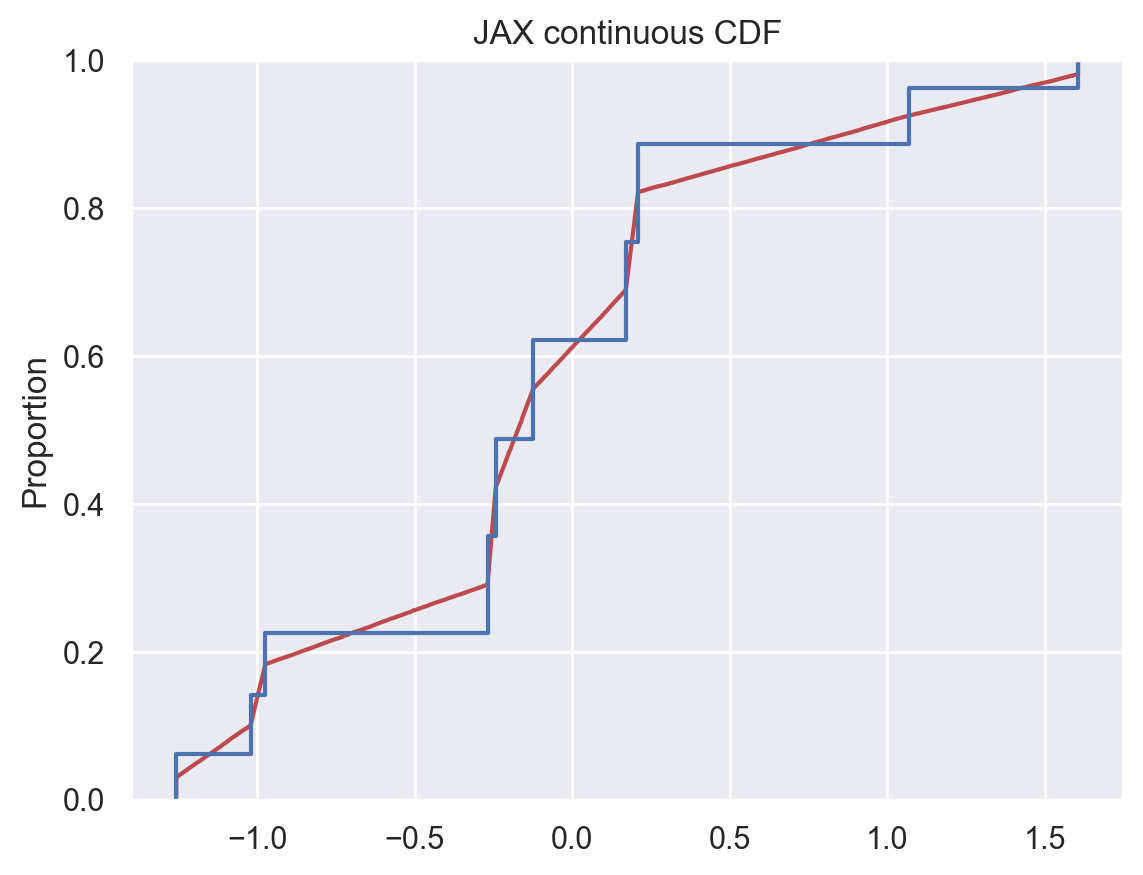

In [3]:
## TEST: continuous CDF 

def sort_marginal_np (x, w):
    """ sort X and and re-arrange w to correspond to sorted indices """
    x_w = dict(zip(x, w))
    sorted_x_dict = dict(sorted(x_w.items(), key = lambda x: x[0]))
    sorted_x = jnp.array(list(sorted_x_dict.keys()))
    sorted_w = jnp.array(list(sorted_x_dict.values()))
    return sorted_x, sorted_w

# generate some data: 
N = 10
rv = stats.norm()
x = rv.rvs(size=N)

w = rv.pdf(x)
w = w / sum(w)

sorted_x, sorted_w = sort_marginal_np(x, w)

sorted_x_jnp = jnp.array(sorted_x)
jnp_sorted_weights = interpolate_weights(jnp.array(sorted_w))
U = random.uniform(random.PRNGKey(0), shape = (100_000,))

jax_samples = jax.vmap(
    continuous_cdf,
    in_axes= (None, None, 0)
)(sorted_x_jnp, jnp_sorted_weights, U)

sns.ecdfplot(x=jax_samples, alpha=0.8, color='firebrick').set(title = 'JAX continuous CDF')
sns.ecdfplot(x=x, weights = w);

In [4]:
## TEST: gaussian copula resampler: 
def jax_sort_marginal (x, w):
    """ sort X and and re-arrange w to correspond to sorted indices """
    x_w = jnp.stack((x, w)).T
    sorted_x, sorted_w = jax.lax.sort_key_val(x, w)
    return {"x": sorted_x, "w": sorted_w}


def gaussian_copula_test (key, X, weights, N):
    """
    Straightforward (numpy-ish) copula for testing
    """
    n, d = X.shape
    # estimate correlation matrix: 
    Y = jnp.zeros((d, n))
    for j in range(d):
        for i in range(n):
            Y = Y.at[j, i].set(sum(jnp.where(X[:, j] <= X[i,j], x = weights, y=0)))
    rho_hat = weighted_corr(jnp.array(Y), weights = weights)

    # gaussian copula: 
    Z = random.multivariate_normal(key=key, mean = jnp.zeros(d), cov = rho_hat, shape = (N,))
    U = jax.scipy.stats.norm.cdf(Z)
    
    x_samples = jnp.zeros((d, N))
    for j in range(d): 
        sorted_marg = jax_sort_marginal(X[:, j], weights) # sort marginal f(x)
        interpolated_w = interpolate_weights(sorted_marg["w"]) # interpolate midpoints between weights
        for i in range(N):
            x_samples = x_samples.at[j, i].set(continuous_cdf(sorted_marg["x"], interpolated_w, U[i, j]))
    return x_samples

In [5]:
_cov = -1
mvn = stats.multivariate_normal(mean = [5, 0.4], cov = [[3, _cov], [_cov, 1]])
mvn2 = stats.multivariate_normal(mean = [1, 0.4], cov = [[2, 0], [0, 1]])
N = 15
X = mvn.rvs(N)
# X = np.random.random(size = (N, 2))
W = uniform(size=N)
W = W/sum(W)

In [6]:
test_resample = gaussian_copula_test(key = random.PRNGKey(0), X = jnp.array(X), weights = jnp.array(W), N=N)

pf_resample = resampler.resample_gaussian_copula(
    key = random.PRNGKey(0), 
    x_particles_prev = jnp.array(X),
    logw = jnp.log(W))

In [7]:
print("Max difference between 2 resamplers: ", jnp.max(test_resample.T - pf_resample["x_particles"]))

Max difference between 2 resamplers:  1.1102230246251565e-16
